# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
poi_detail = pd.read_csv('ctr_data/table_poi_detail.csv')
request_detail = pd.read_csv('ctr_data/table_request_detail.csv')
request_detail.drop_duplicates(subset = 'request_id', keep = 'first', inplace = True)
user_detail = pd.read_csv('ctr_data/table_uuid_detail.csv')
user_detail.drop_duplicates(subset = 'uuid', keep = 'first', inplace = True)
deal_detail = pd.read_csv('ctr_data/table_deal_detail.csv')
train = pd.read_csv('ctr_data/table_impr_click_action_train.csv')
test = pd.read_csv('ctr_data/table_impr_click_action_test.csv')

In [3]:
train['train_test'] = 1
test['train_test'] = 0
train_test = pd.concat([train, test], axis = 0)
#train_test.drop(['ID', 'pos', 'time'], axis = 1, inplace = True)

# Merge 

In [4]:
# Cannot merge user_detail
request_user = request_detail.merge(user_detail, on = 'uuid', how = 'left')
train_test = train_test.merge(request_user, on = 'request_id', how = 'left').\
              merge(poi_detail, on = 'poi_id', suffixes=['_req', '_poi'], how = 'left')
train_test['device_type'].fillna('NA', inplace = True)
train_test['avg_price'].fillna(train_test['avg_price'].mean(), inplace = True)
train_test['age'].fillna(train_test['age'].mean(), inplace = True)
train_test['request_time'].fillna('00', inplace = True)
train_test.fillna(-1.0, inplace = True)

In [5]:
train_test.head()

,ID,action,poi_id,pos,request_id,time,train_test,uuid,cate_id,request_time,...,age,job,cate_level1,cate_level2,cate_level3,area_id,avg_price,poi_star,longitude_poi,latitude_poi
0,-1.0,0.0,1702902487627383470,13.0,4311086084099128885,2019-05-02,1,9.639066e+18,1.0,16:20:24,...,28.021115,1.0,226,201,2036,15743,66.0,43.0,105.716693,29.167927
1,-1.0,0.0,14800569415264211896,1.0,4749834003306548820,2019-05-02,1,1.328961e+18,1.0,19:19:03,...,28.021115,3.0,226,201,244,31806,49.0,37.0,105.440202,38.060255
2,-1.0,0.0,6279863632342018475,83.0,13389247690348720622,2019-05-02,1,1.069036e+19,1.0,17:39:57,...,20.000000,3.0,226,249,12,6941,49.0,48.0,112.568717,22.080556
3,-1.0,0.0,11127900293242244072,43.0,3988416664035581676,2019-05-02,1,3.636211e+18,1.0,22:31:17,...,18.000000,2.0,226,308,321,35343,100.0,39.0,119.348778,29.815176
4,-1.0,0.0,15471065569104080361,13.0,17230175878920950111,2019-05-02,1,4.344248e+18,1.0,18:30:24,...,31.000000,1.0,226,235,235,34029,107.0,50.0,86.770657,43.404640


# Feature Engineering

In [11]:
# Preprocess
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
standard = preprocessing.StandardScaler()
train_test.loc[:, 'device_type'] = pd.Series(encoder.fit_transform(train_test.loc[:, 'device_type']))
train_test['age'] = standard.fit_transform((train_test['age']).values.reshape(-1, 1))
train_test['avg_price'] = standard.fit_transform((train_test['avg_price']).values.reshape(-1, 1))
train_test['poi_star'] = standard.fit_transform((train_test['poi_star']).values.reshape(-1, 1))
#train_temp.loc[:, 'area_id'] = pd.Series(encoder.fit_transform(train_temp.loc[:, 'area_id']))
#train_temp.loc[:, 'cate_id'] = pd.Series(encoder.fit_transform(train_temp.loc[:, 'cate_id']))
#train_temp.loc[:, 'cate_level1'] = pd.Series(encoder.fit_transform(train_temp.loc[:, 'cate_level1']))
#train_temp.loc[:, 'cate_level2'] = pd.Series(encoder.fit_transform(train_temp.loc[:, 'cate_level2']))
#train_temp.loc[:, 'cate_level3'] = pd.Series(encoder.fit_transform(train_temp.loc[:, 'cate_level3']))

In [13]:
train_test['hour'] = train_test['request_time'].apply(lambda x: int(x[0:2]))
train_test['week'] = train_test['time'].apply(lambda x: int(x[-2:])%7)
#train_test.head()

In [15]:
# Discretization By K-means
'''from sklearn.cluster import KMeans
 
kmodel = KMeans(n_clusters = 20, n_jobs = 4) 
kmodel.fit(np.array(train_test['avg_price']).reshape((len(train_test['avg_price']), 1)))
kmodel_pred = kmodel.predict(np.array(train_test['avg_price']).reshape((len(train_test['avg_price']), 1)))
train_test.loc[:, 'avg_price_type'] = kmodel_pred'''

"from sklearn.cluster import KMeans\n \nkmodel = KMeans(n_clusters = 20, n_jobs = 4) \nkmodel.fit(np.array(train_test['avg_price']).reshape((len(train_test['avg_price']), 1)))\nkmodel_pred = kmodel.predict(np.array(train_test['avg_price']).reshape((len(train_test['avg_price']), 1)))\ntrain_test.loc[:, 'avg_price_type'] = kmodel_pred"

In [16]:
train_test.columns

Index(['ID', 'action', 'poi_id', 'pos', 'request_id', 'time', 'train_test',
       'uuid', 'cate_id', 'request_time', 'latitude_req', 'longitude_req',
       'device_type', 'gender', 'age', 'job', 'cate_level1', 'cate_level2',
       'cate_level3', 'area_id', 'avg_price', 'poi_star', 'longitude_poi',
       'latitude_poi', 'hour', 'week'],
      dtype='object')

In [37]:
needed_columns = ['poi_id', 'uuid', 'cate_id', 'hour', 'longitude_req', 'latitude_req',
               'device_type', 'gender', 'age', 'job', 'longitude_poi', 'latitude_poi',
                'cate_level2', 'cate_level3', 'area_id', 'week',
               'avg_price', 'poi_star']

# Train

In [38]:
# Balance need further improvement
train_test1 = train_test[train_test['action'] >= 1]
train_test2 = pd.concat([train_test[train_test['action'] == 0][0:200000],train_test1],axis = 0)

In [39]:
from sklearn import utils

def undersampling(train, undersampling_rate):

    # Get the indices per target value
    idx_0 = train[train.action == 0].index
    idx_1 = train[train.action >= 1].index
    # Get original number of records per target value
    nb_0 = len(train.loc[idx_0])
    nb_1 = len(train.loc[idx_1])
    # Calculate the undersampling rate and resulting number of records with target=0
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with action = 0: {}'.format(undersampling_rate))
    print('Number of records with action = 0 after undersampling: {}'.format(undersampled_nb_0))
    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = utils.shuffle(idx_0, n_samples = undersampled_nb_0)
    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)
    # Return undersample data frame
    train = train.loc[idx_list].reset_index(drop = True)

    return train

In [40]:
train_test_undersampling = undersampling(train_test, 0.06)

Rate to undersample records with action = 0: 0.06
Number of records with action = 0 after undersampling: 246395


In [41]:
x = train_test_undersampling[needed_columns]
y = train_test_undersampling['action'] >= 1
y = y.astype(int)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, random_state = 0)

## LightGBM

In [43]:
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, y_train)
dval = lgb.Dataset(X_val, y_val)

In [44]:
params = {
    'metric':'auc',
    'learning_rate':0.001,
    'num_leaves':127,
    'objective':'binary',
    'n_jobs':6,
    'early_stopping_round': 500,
    'feature_fraction':0.8,
    'feature_fraction_seed':2019
}

In [45]:
clf = lgb.train(params, dtrain, num_boost_round = 5000, valid_sets = dval, verbose_eval = 500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.613877
[1000]	valid_0's auc: 0.61542
[1500]	valid_0's auc: 0.616865
[2000]	valid_0's auc: 0.61808
[2500]	valid_0's auc: 0.61901
[3000]	valid_0's auc: 0.619977
[3500]	valid_0's auc: 0.620945
[4000]	valid_0's auc: 0.621679
[4500]	valid_0's auc: 0.622074
[5000]	valid_0's auc: 0.622341
Did not meet early stopping. Best iteration is:
[4999]	valid_0's auc: 0.622341


### LightGBM Parameter tuning

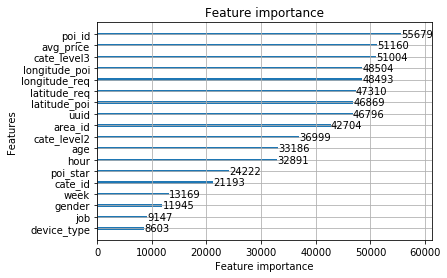

In [46]:
lgb.plot_importance(clf, max_num_features = 20)

# Test w = 0.06

In [26]:
a = train_test[train_test['action'] == -1]

In [27]:
preds_xgb_test = clf.predict(a[needed_columns])
preds_xgb_test_re = preds_xgb_test/(preds_xgb_test+(1-preds_xgb_test)/0.06)

In [28]:
testoutput = pd.DataFrame()
testoutput['action'] = preds_xgb_test_re
testoutput.index.name = 'ID'

In [29]:
testoutput.to_csv('output/testoutputV2.09.csv')

In [30]:
train_test['action'].value_counts()

 0.0     4106584
-1.0      192000
 1.0       92189
 2.0        6216
 3.0         850
 4.0         190
 5.0          61
 6.0          19
 7.0           7
 8.0           2
 11.0          1
 9.0           1
Name: action, dtype: int64

In [31]:
testoutput.mean()

action    0.023819
dtype: float64